使用设备: mps
开始加载图像...
图像加载成功。


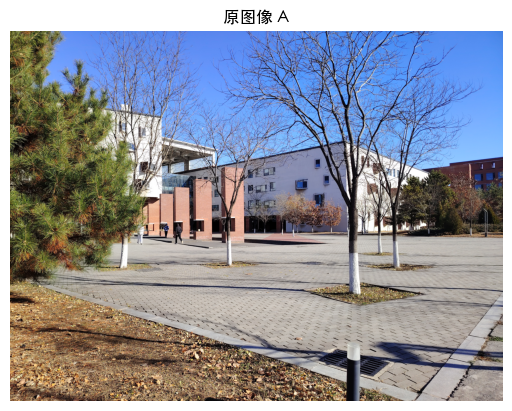

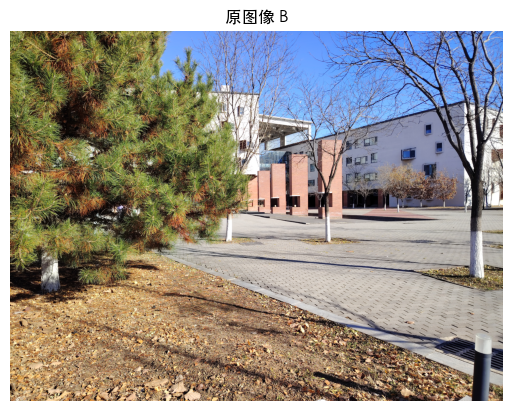

正在处理 图像 A 的特征点检测和描述...
图像 A 检测到 500 个关键点。
图像 A 有效的关键点数量：497


提取 图像 A 特征: 100%|██████████| 8/8 [00:06<00:00,  1.29it/s]


图像 A 特征描述符提取完成，特征数量：(497, 512)
正在处理 图像 B 的特征点检测和描述...
图像 B 检测到 500 个关键点。
图像 B 有效的关键点数量：495


提取 图像 B 特征: 100%|██████████| 8/8 [00:02<00:00,  3.65it/s]


图像 B 特征描述符提取完成，特征数量：(495, 512)
开始匹配特征点...
匹配完成，找到 53 对好的匹配点。
正在绘制匹配结果...
开始计算单应性矩阵并拼接图像...
内点数量：18，外点数量：35.0
图像拼接完成。


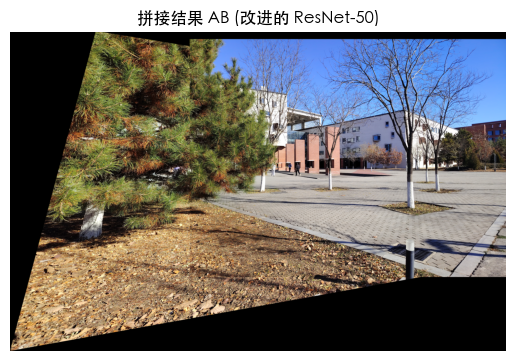

拼接结果已保存至: ./output_Improved_ResNet50/stitched_3_4.jpg
提取图像特征的帧率: 0.18 FPS


In [6]:
import cv2
import numpy as np
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import time


def calculate_fps(start_time, end_time, total_images_processed):
    """
    计算处理速度，帧率（FPS）
    :param start_time: 处理开始时间
    :param end_time: 处理结束时间
    :param total_images_processed: 总共处理的图像数量
    :return: 每秒处理的图像数量（FPS）
    """
    elapsed_time = end_time - start_time
    fps = total_images_processed / elapsed_time
    return fps

# 设置全局字体
plt.rcParams['font.sans-serif'] = ['STHeiti']  # 使用黑体
plt.rcParams['axes.unicode_minus'] = False    # 解决负号显示问题

# ============================
# 配置参数
# ============================

imageA_path = "../datasets/new_data/3.jpg"  # 图像 A 的路径
imageB_path = "../datasets/new_data/4.jpg"  # 图像 B 的路径

# 匹配参数
distance_ratio = 0.9     # Lowe 的比率测试中的距离比
ransac_threshold = 5.0      # RANSAC 阈值
min_matches_required = 4    # 计算单应性矩阵所需的最小匹配点数量
max_keypoints = 500         # 每幅图像中最多使用的关键点数量

# 设备配置
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# 选择设备：使用 MPS（Metal Performance Shaders）在 Apple Silicon 上进行计算，或者回退到 CPU
device = torch.device('mps' if torch.backends.mps.is_built() else 'cpu')

print(f"使用设备: {device}")

# ============================
# 定义 SE-Block 注意力机制
# ============================
class SELayer(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SELayer, self).__init__()

        # 全局平均池化
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)

        # 两个全连接层
        self.fc = nn.Sequential(

            # 第一个全连接层，瓶颈层，减少特征通道数
            # 将通道数减少到原来的 1/reduction
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),

            # 第二个全连接层，恢复特征通道数
            # Liner的参数为输入和输出的维度
            nn.Linear(channel // reduction, channel, bias=False),

            # 激活函数，将输出(每个通道的权重)限制在 [0, 1] 之间
            nn.Sigmoid()
        )

    def forward(self, x):

        # 输入 x 的维度为 [b, c, h, w]
        b, c, _, _ = x.size()

        # 对输入张量 x 执行全局平均池化操作，输出的尺寸是 [batch_size, channels, 1, 1]
        y = self.global_avg_pool(x).view(b, c)

        # 池化后的输出通过两层全连接层进行处理；与原始输入特征图的形状进行广播
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

# ============================
# 定义改进的 ResNet-50 模型
# ============================
class ImprovedResNet50(nn.Module):
    def __init__(self):
        super(ImprovedResNet50, self).__init__()
        # 加载预训练的 ResNet-50 模型
        self.resnet = models.resnet50(pretrained=True)
        
        # 提取 ResNet-50 的前四个卷积层（到 layer3）
        self.layer0 = nn.Sequential(self.resnet.conv1,
                                    self.resnet.bn1,
                                    self.resnet.relu,
                                    self.resnet.maxpool)
        
        # 提取低级特征，例如边缘和纹理
        self.layer1 = self.resnet.layer1  # 输出通道数为 256

        # 提取中级特征，例如形状和局部区域
        self.layer2 = self.resnet.layer2  # 输出通道数为 512

        # 提取高级特征，例如物体结构和语义信息
        self.layer3 = self.resnet.layer3  # 输出通道数为 1024

        # 添加 SE 注意力机制到每个层，自适应地重新校准通道之间的关系
        self.se1 = SELayer(256)
        self.se2 = SELayer(512)
        self.se3 = SELayer(1024)

        # 自定义的特征融合层
        self.conv_fusion = nn.Conv2d(256 + 512 + 1024, 512, kernel_size=1)

        # 输出描述符维度
        self.descriptor_dim = 512

        # 冻结模型参数（除非进行微调，保持预训练模型的特征提取能力）
        for param in self.parameters():
            param.requires_grad = False

    def forward(self, x):
        # 提取多层特征
        x0 = self.layer0(x)
        x1 = self.layer1(x0)
        x1 = self.se1(x1)
        x2 = self.layer2(x1)
        x2 = self.se2(x2)
        x3 = self.layer3(x2)
        x3 = self.se3(x3)

        # 上采样，使所有特征图大小一致
        x1_up = nn.functional.interpolate(x1, size=x3.size()[2:], mode='bilinear', align_corners=False)
        x2_up = nn.functional.interpolate(x2, size=x3.size()[2:], mode='bilinear', align_corners=False)

        # 特征融合
        x_fused = torch.cat([x1_up, x2_up, x3], dim=1)

        # 使用 1x1 卷积层进行特征融合（512）
        x_fused = self.conv_fusion(x_fused)

        # 特征图全局平均池化，得到描述符（512维的特征描述符）
        descriptor = nn.functional.adaptive_avg_pool2d(x_fused, (1, 1)).view(x.size(0), -1)

        return descriptor

# 实例化模型
model = ImprovedResNet50().to(device)
model.eval()  # 设置为评估模式

# 图像预处理
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ResNet 的标准化参数
                         std=[0.229, 0.224, 0.225]),
])

def show_image(image, title="Image"):
    """
    显示图像的辅助函数，支持彩色和灰度图显示
    """
    if len(image.shape) == 2:
        plt.imshow(image, cmap='gray')
    else:
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()

def detectAndDescribe(image, image_name="Image"):
    """
    使用 SIFT 检测关键点，并使用改进的 ResNet-50 提取特征描述符
    """
    print(f"正在处理 {image_name} 的特征点检测和描述...")

    # 转换为灰度图像
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # 使用 SIFT 检测关键点
    sift = cv2.SIFT_create(nfeatures=max_keypoints)
    keypoints = sift.detect(gray, None)
    keypoints = sorted(keypoints, key=lambda x: -x.response)[:max_keypoints]
    print(f"{image_name} 检测到 {len(keypoints)} 个关键点。")

    # 提取每个关键点的特征描述符
    descriptors = []
    valid_keypoints = []
    patches = []

    patch_size = 32  # 图像块大小

    for kp in keypoints:
        x, y = int(round(kp.pt[0])), int(round(kp.pt[1]))
        x1 = x - patch_size // 2
        y1 = y - patch_size // 2
        x2 = x + patch_size // 2
        y2 = y + patch_size // 2

        # 检查边界
        if x1 >= 0 and y1 >= 0 and x2 <= image.shape[1] and y2 <= image.shape[0]:
            patch = image[y1:y2, x1:x2]
            patches.append(patch)
            valid_keypoints.append(kp)
        else:
            continue

    print(f"{image_name} 有效的关键点数量：{len(valid_keypoints)}")

    # 批量处理图像块，提取特征描述符
    batch_size = 64
    for i in tqdm(range(0, len(patches), batch_size), desc=f"提取 {image_name} 特征"):
        batch_patches = patches[i:i+batch_size]
        batch_tensors = [transform(cv2.resize(patch, (224, 224))) for patch in batch_patches]
        batch_tensors = torch.stack(batch_tensors).to(device)
        with torch.no_grad():
            batch_descriptors = model(batch_tensors)
            descriptors.extend(batch_descriptors.cpu().numpy())

    descriptors = np.array(descriptors)
    print(f"{image_name} 特征描述符提取完成，特征数量：{descriptors.shape}")
    return valid_keypoints, descriptors

def match_keypoints(desA, desB):
    """
    使用 BFMatcher 进行特征匹配，并应用 Lowe 的比率测试筛选优秀匹配点
    """
    print("开始匹配特征点...")
    # 转换描述符为 np.float32 类型
    desA = desA.astype(np.float32)
    desB = desB.astype(np.float32)

    matcher = cv2.BFMatcher(cv2.NORM_L2)
    raw_matches = matcher.knnMatch(desA, desB, k=2)

    # 应用 Lowe 的比率测试
    good_matches = []
    matches = []
    for m, n in raw_matches:
        if m.distance < distance_ratio * n.distance:
            good_matches.append([m])
            matches.append((m.queryIdx, m.trainIdx))

    print(f"匹配完成，找到 {len(good_matches)} 对好的匹配点。")
    return good_matches, matches

def draw_matches(imageA, kpsA, imageB, kpsB, good_matches):
    """
    绘制两个图像之间的匹配结果
    """
    print("正在绘制匹配结果...")
    # 自定义绘图参数
    draw_params = dict(
        matchColor=(0, 255, 0),       # 匹配的线为绿色
        singlePointColor=(255, 0, 0), # 未匹配的点为蓝色
        matchesMask=None,             # 不使用掩码
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
    )
    vis = cv2.drawMatchesKnn(imageB, kpsB, imageA, kpsA, good_matches, None, **draw_params)
    return vis

def stitch_images(center_image, align_image, center_kps, align_kps, matches):
    """
    利用匹配点计算单应性矩阵并进行图像拼接
    """
    print("开始计算单应性矩阵并拼接图像...")
    if len(matches) > min_matches_required:
        pts_center = np.float32([center_kps[i].pt for (i, _) in matches])
        pts_align = np.float32([align_kps[i].pt for (_, i) in matches])

        # 使用 RANSAC 计算单应性矩阵
        H, status = cv2.findHomography(pts_align, pts_center, cv2.RANSAC, ransac_threshold)

        # 提取内点
        inlier_pts_center = pts_center[status.ravel() == 1]
        inlier_pts_align = pts_align[status.ravel() == 1]

        print(f"内点数量：{np.sum(status)}，外点数量：{len(status) - np.sum(status)}")

        # 创建合并的图像用于显示
        combined_image = np.hstack((center_image, align_image))
        offset = center_image.shape[1]

        # 绘制匹配对，增强可见性
        for pt_center, pt_align in zip(inlier_pts_center, inlier_pts_align):
            pt_center = (int(pt_center[0]), int(pt_center[1]))
            pt_align = (int(pt_align[0] + offset), int(pt_align[1]))
            cv2.circle(combined_image, pt_center, 8, (0, 255, 0), -1)  # 中心图像的点（绿色）
            cv2.circle(combined_image, pt_align, 8, (255, 0, 0), -1)   # 对齐图像的点（蓝色）
            cv2.line(combined_image, pt_center, pt_align, (0, 0, 255), 2)  # 连接线（红色，粗线）

        # show_image(combined_image, "用于单应性矩阵计算的匹配对（内点）")

        # 拼接图像
        height_center, width_center = center_image.shape[:2]
        height_align, width_align = align_image.shape[:2]
        # 计算输出图像尺寸
        corners_center = np.float32([[0, 0], [0, height_center], [width_center, height_center], [width_center, 0]]).reshape(-1, 1, 2)
        corners_align = np.float32([[0, 0], [0, height_align], [width_align, height_align], [width_align, 0]]).reshape(-1, 1, 2)
        corners_align_transformed = cv2.perspectiveTransform(corners_align, H)
        all_corners = np.concatenate((corners_center, corners_align_transformed), axis=0)
        [x_min, y_min] = np.int32(all_corners.min(axis=0).ravel())
        [x_max, y_max] = np.int32(all_corners.max(axis=0).ravel())
        translation_dist = [-x_min, -y_min]

        H_translation = np.array([[1, 0, translation_dist[0]],
                                  [0, 1, translation_dist[1]],
                                  [0, 0, 1]])

        result = cv2.warpPerspective(align_image, H_translation @ H, (x_max - x_min, y_max - y_min))
        result[translation_dist[1]:height_center+translation_dist[1], translation_dist[0]:width_center+translation_dist[0]] = center_image

        print("图像拼接完成。")
        return result
    else:
        print(f"未找到足够的匹配点（需要至少 {min_matches_required} 个）")
        return None

def show_keypoints(image, keypoints, title="Keypoints"):
    """
    显示特征点，并使用较大的圆圈标注特征点位置
    """
    print(f"正在绘制 {title} ...")
    # 创建一个空白图像用于绘制
    image_with_keypoints = image.copy()
    # 增强特征点的可见性
    for kp in keypoints:
        x, y = int(kp.pt[0]), int(kp.pt[1])
        cv2.circle(image_with_keypoints, (x, y), 6, (0, 255, 0), 2)  # 绿色圆圈，较大
    show_image(image_with_keypoints, title)

# 加载图像并执行拼接
print("开始加载图像...")
imageA = cv2.imread(imageA_path)
imageB = cv2.imread(imageB_path)

# # 将图片大小设为640x480
# imageA = cv2.resize(imageA, (640, 480))
# imageB = cv2.resize(imageB, (640, 480))


# 确保图像加载成功
if imageA is None or imageB is None:
    print("Error: Could not load one or both images.")
else:
    print("图像加载成功。")
    show_image(imageA, '原图像 A')
    show_image(imageB, '原图像 B')

    # 提取并显示特征点和描述符
    start_time = time.time()
    kpsA, desA = detectAndDescribe(imageA, "图像 A")
    kpsB, desB = detectAndDescribe(imageB, "图像 B")
    end_time = time.time()
    fps = calculate_fps(start_time, end_time, total_images_processed=2)

    # 显示特征点
    # show_keypoints(imageA, kpsA, '图像 A 的特征图')
    # show_keypoints(imageB, kpsB, '图像 B 的特征图')

    # 使用 BFMatcher 匹配特征
    good_matches_AB, matches_AB = match_keypoints(desA, desB)

    # 显示匹配结果
    vis_AB = draw_matches(imageA, kpsA, imageB, kpsB, good_matches_AB)
    # if vis_AB is not None:
    #     show_image(vis_AB, '特征点匹配 A-B (改进的 ResNet-50)')

    # 图像拼接
    stitchedAB = stitch_images(imageA, imageB, kpsA, kpsB, matches_AB)
    if stitchedAB is not None:


        show_image(stitchedAB, '拼接结果 AB (改进的 ResNet-50)')


        # 保存拼接结果
        baseA = os.path.basename(imageA_path)[-7:-4]
        baseB = os.path.basename(imageB_path)[-7:-4]
        output_dir = './output_Improved_ResNet50'
        output_filename = f"{output_dir}/stitched_{baseA}_{baseB}.jpg"
        os.makedirs(output_dir, exist_ok=True)
        cv2.imwrite(output_filename, stitchedAB)
        print(f"拼接结果已保存至: {output_filename}")
    else:
        print("由于匹配点不足，拼接失败。")

    print(f"提取图像特征的帧率: {fps:.2f} FPS")
    
